In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import time

2023-04-17 10:57:23.041650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 10:57:24.093471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jglane/.conda/envs/cent7/2020.11-py38/my_tf_env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

2023-04-17 10:57:26.657613: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
img_shape = (64, 64, 3)

ds, ds_info = tfds.load('cycle_gan/apple2orange', with_info=True, as_supervised=True)

ds_train_apple = ds['trainA']
ds_train_orange = ds['trainB']

ds_test_apple = ds['testA']
ds_test_orange = ds['testB']

2023-04-17 10:57:27.096546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-04-17 10:57:27.096878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


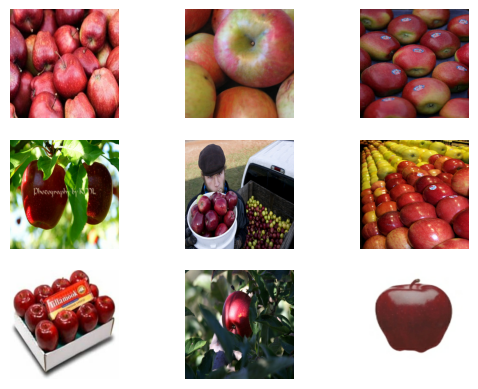

In [4]:
fig, ax = plt.subplots(3, 3)
it = iter(ds_train_apple)
for i in range(3):
    for j in range(3):
        img = next(it)[0].numpy()
        ax[i][j].imshow(img)
        ax[i][j].axis('off')

In [5]:
def resize_and_normalize(img: tf.Tensor):
    return tf.image.resize(img, (img_shape[0], img_shape[1])) / 255

@tf.function()
def random_jitter(img: tf.Tensor):
    img_shape = img.shape
    img = tf.image.resize(img, [img_shape[0] + img_shape[0] // 10, img_shape[1] + img_shape[1] // 10], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # add 10% to the size
    img = tf.image.random_crop(img, size=(img_shape[0], img_shape[1], 3)) # random crop back to the original size
    if tf.random.uniform(()) > 0.5: # 50% chance to flip the image
        img = tf.image.flip_left_right(img)
    return img

def preprocess_image_train(img, label):
    img = resize_and_normalize(img)
    img = random_jitter(img)
    return img

def preprocess_image_test(img, label):
    img = resize_and_normalize(img)
    return img

In [6]:
ds_train_apple = ds_train_apple.map(preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(ds_info.splits['trainA'].num_examples).batch(1)
ds_train_orange = ds_train_orange.map(preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(ds_info.splits['trainB'].num_examples).batch(1)
ds_test_apple = ds_test_apple.map(preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(ds_info.splits['testA'].num_examples).batch(1)
ds_test_orange = ds_test_orange.map(preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(ds_info.splits['testB'].num_examples).batch(1)

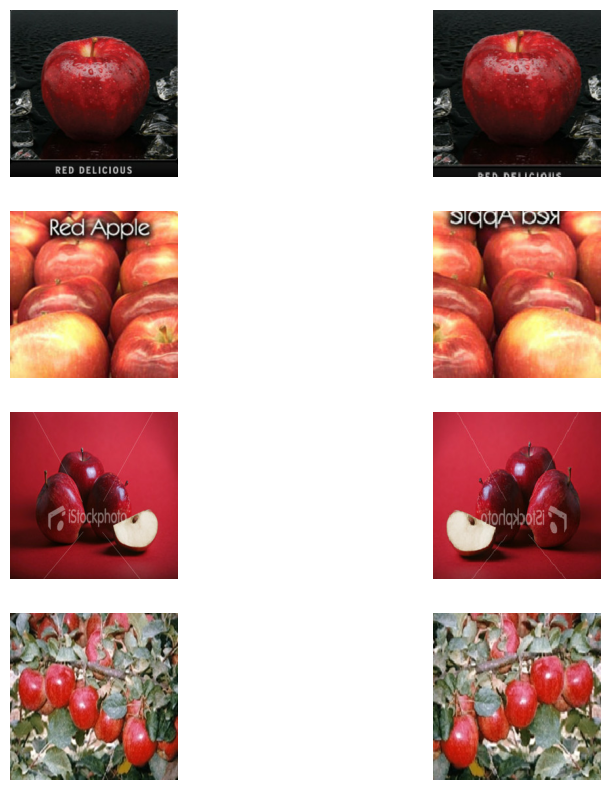

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
for i in range(4):
    img = next(it)[0].numpy()
    ax[i][0].imshow(img)
    ax[i][0].axis('off')
    ax[i][1].imshow(random_jitter(img))
    ax[i][1].axis('off')

In [8]:
class Residual(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides, padding='same', activation='relu'):
        super(Residual, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding, activation=activation)
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.activation = activation

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        out = tf.keras.layers.add([x, inputs])
        return tf.keras.layers.ReLU()(out)

In [17]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((128, 128, 3)))

    # c7s1-64
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=1, padding='same'))
    model.add(tfa.layers.InstanceNormalization())
    model.add(tf.keras.layers.ReLU())

    # d128
    model.add(tfa.layers.ReflectionPadding2D((1, 1))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(tf.keras.layers.ReLU())

    # d256
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(tf.keras.layers.ReLU())
    
    # 6 x R256
    model.add(Residual(filters=256, kernel_size=3, strides=1))
    model.add(Residual(filters=256, kernel_size=3, strides=1))
    model.add(Residual(filters=256, kernel_size=3, strides=1))
    model.add(Residual(filters=256, kernel_size=3, strides=1))
    model.add(Residual(filters=256, kernel_size=3, strides=1))
    model.add(Residual(filters=256, kernel_size=3, strides=1))

    # u128
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same'))
    model.add(tfa.layers.InstanceNormalization())
    model.add(tf.keras.layers.ReLU())

    # u64
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same'))
    model.add(tfa.layers.InstanceNormalization())
    model.add(tf.keras.layers.ReLU())

    # c7s1-3
    model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=7, strides=1, padding='same', activation='tanh'))

    return model

build_generator().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 128, 128, 64)      9472      
                                                                 
 instance_normalization_20 (  (None, 128, 128, 64)     128       
 InstanceNormalization)                                          
                                                                 
 re_lu_5 (ReLU)              (None, 128, 128, 64)      0         
                                                                 
 conv2d_41 (Conv2D)          (None, 63, 63, 128)       73856     
                                                                 
 instance_normalization_21 (  (None, 63, 63, 128)      256       
 InstanceNormalization)                                          
                                                                 
 re_lu_6 (ReLU)              (None, 63, 63, 128)      

In [15]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((256, 256, 3)))
    
    # C64
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2))
    model.add(tf.keras.layers.LeakyReLU(0.2))

    # C128
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    # C256
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=4, strides=2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    # C512
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=4, strides=2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    # convolution that outputs 1 value
    model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, activation='sigmoid'))

    return model

build_discriminator().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 127, 127, 64)      3136      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
 conv2d_36 (Conv2D)          (None, 62, 62, 128)       131200    
                                                                 
 instance_normalization_17 (  (None, 62, 62, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 62, 62, 128)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 30, 30, 256)       524544    
                                                      

In [11]:
G = build_generator()
F = build_generator()

D_X = build_discriminator()
D_Y = build_discriminator()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
lambd = 10

def discriminator_loss(real, fake):
    real_loss = loss(tf.ones_like(real), real)
    fake_loss = loss(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) / 2

def generator_loss(fake):
    return loss(tf.ones_like(fake), fake)

def cycle_loss(real, cycled):
    return lambd * tf.reduce_mean(tf.abs(real - cycled))

def identity_loss(real, same):
    return lambd * tf.reduce_mean(tf.abs(real - same)) / 2

learning_rate = 0.0002

G_opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
F_opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
D_X_opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
D_Y_opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)

In [12]:
@tf.function()
def train_step(real_X, real_Y):
    with tf.GradientTape(persistent=True) as tape:
        # Generate images
        fake_Y = G(real_X, training=True)
        cycled_X = F(fake_Y, training=True)
        fake_X = F(real_Y, training=True)
        cycled_Y = G(fake_X, training=True)
        same_X = F(real_X, training=True)
        same_Y = G(real_Y, training=True)

        D_X_real = D_X(real_X, training=True)
        D_X_fake = D_X(fake_X, training=True)
        D_Y_real = D_Y(real_Y, training=True)
        D_Y_fake = D_Y(fake_Y, training=True)

        total_cycle_loss = cycle_loss(real_X, cycled_X) + cycle_loss(real_Y, cycled_Y)
        G_loss = generator_loss(D_Y_fake) + identity_loss(real_Y, same_Y) + total_cycle_loss
        F_loss = generator_loss(D_X_fake) + identity_loss(real_X, same_X) + total_cycle_loss

        D_X_loss = discriminator_loss(D_X_real, D_X_fake)
        D_Y_loss = discriminator_loss(D_Y_real, D_Y_fake)

    # Calculate the gradients for generator and discriminator
    G_grad = tape.gradient(G_loss, G.trainable_variables)
    F_grad = tape.gradient(F_loss, F.trainable_variables)

    D_X_grad = tape.gradient(D_X_loss, D_X.trainable_variables)
    D_Y_grad = tape.gradient(D_Y_loss, D_Y.trainable_variables)

    # Apply the gradients to the optimizer
    G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
    F_opt.apply_gradients(zip(F_grad, F.trainable_variables))

    D_X_opt.apply_gradients(zip(D_X_grad, D_X.trainable_variables))
    D_Y_opt.apply_gradients(zip(D_Y_grad, D_Y.trainable_variables))

    return G_loss, F_loss, D_X_loss, D_Y_loss

In [14]:
epochs = 10

for epoch in range(epochs):
    start = time.time()

    print(f'Epoch: {epoch + 1}/{epochs} ', end='')
    for X, Y in tf.data.Dataset.zip((ds_train_apple, ds_train_orange)):
        #G_loss, F_loss, D_X_loss, D_Y_loss = train_step(X, Y)
        print('.', end='')
    
    test_img = next(iter(ds_test_apple))
    plt.imsave(f'samples/epoch_{epoch + 1}.png', np.concatenate((test_img[0], G(test_img, training=False).numpy()[0]), axis=1))

    end = time.time()
    print(f'\n    Time: {end - start} s')

Epoch: 1/10 

2023-04-14 19:23:43.062089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype int64 and shape [1]
	 [[{{node Placeholder/_37}}]]
2023-04-14 19:23:43.062639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype int64 and shape [1]
	 [[{{node Placeholder/_36}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

2023-04-14 19:23:44.187896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-04-14 19:23:44.188267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]



    Time: 2.8170690536499023 s
Epoch: 2/10 

2023-04-14 19:23:45.879627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_34' with dtype string and shape [1]
	 [[{{node Placeholder/_34}}]]
2023-04-14 19:23:45.880167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    

2023-04-14 19:23:48.176195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_34' with dtype string and shape [1]
	 [[{{node Placeholder/_34}}]]
2023-04-14 19:23:48.176739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    

2023-04-14 19:23:50.283813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype int64 and shape [1]
	 [[{{node Placeholder/_36}}]]
2023-04-14 19:23:50.284354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    

2023-04-14 19:23:52.478070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype int64 and shape [1]
	 [[{{node Placeholder/_36}}]]
2023-04-14 19:23:52.478626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype int64 and shape [1]
	 [[{{node Placeholder/_37}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    

2023-04-14 19:23:55.073328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype int64 and shape [1]
	 [[{{node Placeholder/_37}}]]
2023-04-14 19:23:55.073882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    

2023-04-14 19:23:56.777421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype int64 and shape [1]
	 [[{{node Placeholder/_37}}]]
2023-04-14 19:23:56.777962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype string and shape [1]
	 [[{{node Placeholder/_33}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    

2023-04-14 19:23:59.076873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype string and shape [1]
	 [[{{node Placeholder/_33}}]]
2023-04-14 19:23:59.077403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_34' with dtype string and shape [1]
	 [[{{node Placeholder/_34}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    

2023-04-14 19:24:00.973643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_35' with dtype string and shape [1]
	 [[{{node Placeholder/_35}}]]
2023-04-14 19:24:00.974185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    

2023-04-14 19:24:03.376573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype string and shape [1]
	 [[{{node Placeholder/_33}}]]
2023-04-14 19:24:03.377322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype int64 and shape [1]
	 [[{{node Placeholder/_37}}]]


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
    